# Importing Data

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
path = "/kaggle/input/snakeclef-2022-reordered/SnakeCLEF2022-small_size/"

In [24]:
image_size = 256
batch_size = 32
channels = 3

In [27]:
tf.__version__

'2.15.0'

In [36]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    
    shuffle=True,
    seed=69,
    
    image_size = (image_size,image_size),
    batch_size = 32
)

Found 270249 files belonging to 1572 classes.


# Data Viz

In [55]:
class_names = dataset.class_names
for i in range(10):
    print(class_names[i])

Acanthophis_antarcticus
Acanthophis_laevis
Acanthophis_praelongus
Acanthophis_pyrrhus
Acanthophis_rugosus
Acanthophis_wellsi
Achalinus_formosanus
Achalinus_niger
Achalinus_rufescens
Achalinus_spinalis


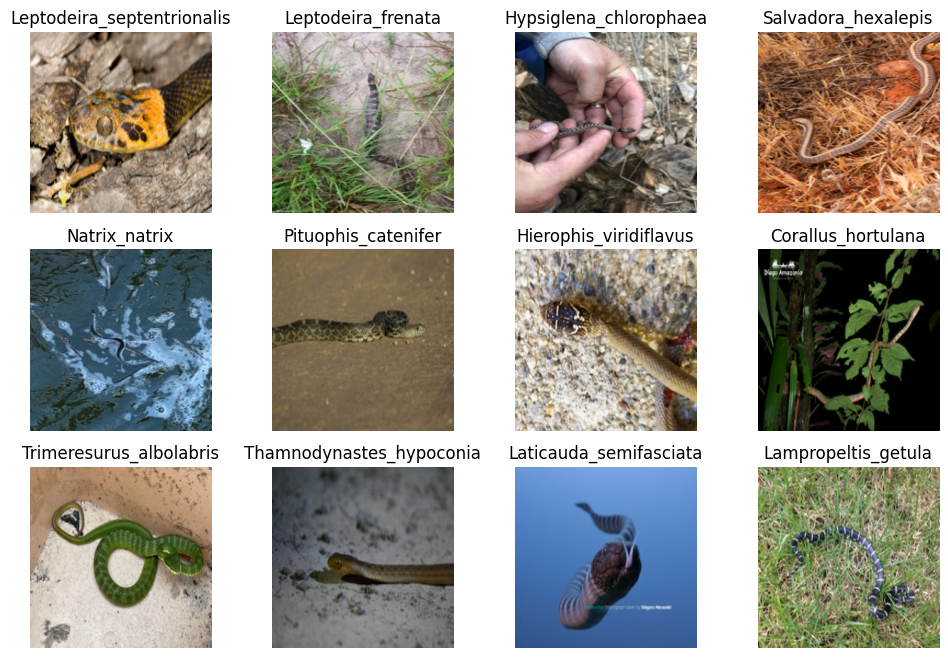

In [71]:
plt.figure(figsize=(12, 8))

for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        
        plt.axis("off")
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
#         print(labels_batch[i])
        
        plt.title(
            class_names[
                np.array([labels_batch[i]])[0]
            ]
        
        )
        

In [72]:
train_size = 0.8
val_size = 0.1
test_size = 0.1

# Dataset Splitting

In [73]:
len(dataset) # Number of batches

8446

In [75]:
def train_val_test_split_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=69)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [77]:
train_ds, val_ds, test_ds = train_val_test_split_tf(dataset)

In [79]:
len(dataset), len(train_ds), len(val_ds), len(test_ds)# Number of batches

(8446, 6756, 844, 846)

# Catch, Shuffle and Prefetch

In [80]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Building

### Resizing and Rescaling

In [82]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(image_size, image_size),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation (Not recommended for large datasets)

In [83]:
data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

In [84]:
train_ds = train_ds.map(
    lambda x, y: 
    (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [90]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 1572

model = tf.keras.models.Sequential([
    resize_and_rescale,
    
    tf.keras.layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [91]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [92]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# T